In [3]:
import sys
import os
import shutil
import json
import ast

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
plt.style.use("seaborn-whitegrid")
import seaborn as sns
sns.set_style("whitegrid")

import tensorflow as tf
print("tensorflow:", tf.__version__)
from tensorflow import keras
print("keras:", keras.__version__)
import keras_tuner as kt
print("keras_tuner:", kt.__version__)

from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Check if tensorflow can use your GPU
tf.config.list_physical_devices('GPU')

tensorflow: 2.9.1
keras: 2.9.0
keras_tuner: 1.1.3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
tf.config.set_visible_devices([], 'GPU')

In [4]:
# Random_state seed
RS = 1234

In [5]:
# 1. Obtain parameters for the different analyses ----------------------------------------
# par_file = sys.argv[1]
# row_number = int(sys.argv[2])

# par_file = "AroAdm_kerPC.csv"
par_file = "AroAdm_top-markers-10k.csv"
row_number = 11

# Load grid
par_grid = pd.read_csv(os.path.join("parameters", par_file))
par_grid

,model_type,architecture,m_set,traits,part,input_type,output_type
0,top-markers-10k,MLP,SNP,culm.diameter.1st.internode,AroAdm,single-input,single-output
1,top-markers-10k,MLP,SNP,leaf.senescence,AroAdm,single-input,single-output
2,top-markers-10k,MLP,SNP,grain.weight,AroAdm,single-input,single-output
3,top-markers-10k,MLP,SNP,time.to.flowering.from.sowing,AroAdm,single-input,single-output
4,top-markers-10k,MLP,all,culm.diameter.1st.internode,AroAdm,single-input,single-output
5,top-markers-10k,MLP,all,leaf.senescence,AroAdm,single-input,single-output
6,top-markers-10k,MLP,all,grain.weight,AroAdm,single-input,single-output
7,top-markers-10k,MLP,all,time.to.flowering.from.sowing,AroAdm,single-input,single-output
8,top-markers-10k,CNN,SNP,culm.diameter.1st.internode,AroAdm,single-input,single-output
9,top-markers-10k,CNN,SNP,leaf.senescence,AroAdm,single-input,single-output


In [6]:
# Extract parameters =====================================================================

# Which row of the grid
pars = par_grid.iloc[row_number]
print(pars, "\n")

# Model type: top-markers-10k or kerPC
model_type = pars["model_type"]

# Common pars
architecture = pars["architecture"]
m_set = pars["m_set"]
traits = pars["traits"]
part = pars["part"]
input_type = pars["input_type"]
output_type = pars["output_type"]

# Output folder
out_folder = os.path.join("models", f"{model_type}_{architecture}_{m_set}_{input_type}", traits, part)
if not os.path.isdir(out_folder):
    os.makedirs(out_folder)
print(out_folder)

# Save traits as list
# If multi-output, change literal string to list
if output_type == "multi-output":
    traits = ast.literal_eval(traits)
else:
    traits = [traits]
print(traits)

# Target variable type
# Save as list, just like traits
target_dict = {
    "culm.diameter.1st.internode": "binary",
    "leaf.senescence": "binary",
    "grain.weight": "continuous",
    "time.to.flowering.from.sowing": "continuous"
}

target_types = []
for trait_i in traits:
    if trait_i not in target_dict.keys():
        print("Define variable type of the target in the dictionary")
        exit(1)
    target_types.append(target_dict[trait_i])

print(target_types)

model_type                    top-markers-10k
architecture                              CNN
m_set                                     SNP
traits          time.to.flowering.from.sowing
part                                   AroAdm
input_type                       single-input
output_type                     single-output
Name: 11, dtype: object 

models/top-markers-10k_CNN_SNP_single-input/time.to.flowering.from.sowing/AroAdm
['time.to.flowering.from.sowing']
['continuous']


In [7]:
# 3. Prepare data ------------------------------------------------------------------------

# Features ===============================================================================
# Generate X_list, even if single-input

# Top-markers-10k
if model_type == "top-markers-10k":
    X_list = []
    X_scaler_list = []
    
    # For every trait, 10k most associated markers
    for i in range(len(traits)):
        X_name = f"geno_top-10000-{m_set}_{part}_{traits[i]}.csv"
        # Load and remove accession column
        X_df = pd.read_csv(os.path.join("data", model_type, X_name))
        X_df = X_df.iloc[:, 1:]
        
        X = X_df.to_numpy()
        # Scale using all data because genomic prediction
        scaler_X_all = StandardScaler()
        scaler_X_all.fit(X)
        X = scaler_X_all.transform(X)
        
        X_list.append(X)
        X_scaler_list.append(scaler_X_all)
        
# kerPC
elif model_type == "kerPC":
    # Save initial list with kerPCs based on marker set
    X_list_initial = []
    
    # Define marker sets
    if m_set == "SNP":
        marker_sets = ["SNP"]
    elif m_set == "all":
        marker_sets = ["DEL", "DUP", "INV", "MITE-DTX", "RLX-RIX", "SNP"]
    
    # Load matrices
    for i in range(len(marker_sets)):
        X_name = f"PC_{marker_sets[i]}.csv"
        X_df = pd.read_csv(os.path.join("data", model_type, X_name))
        X_df = X_df.iloc[:, 1:]
        
        X = X_df.to_numpy()
        X_list_initial.append(X)
    
    # Process depending on input-type
    X_list = []
    X_scaler_list = []
    
    # If single-input, concatenate matrices of list
    if input_type == "single-input":
        for i in range(len(X_list_initial)):
            if i == 0:
                X = X_list_initial[i]
                continue
            
            X = np.concatenate((X, X_list_initial[i]), axis = 1)
        
        # Scale using all data because genomic prediction
        scaler_X_all = StandardScaler()
        scaler_X_all.fit(X)
        X = scaler_X_all.transform(X)
        
        X_list.append(X)
        X_scaler_list.append(scaler_X_all)
    # Multi-input
    else:
        for i in range(len(X_list_initial)):
            X = X_list_initial[i]
            
            # Scale using all data because genomic prediction
            scaler_X_all = StandardScaler()
            scaler_X_all.fit(X)
            X = scaler_X_all.transform(X)
            
            X_list.append(X)
            X_scaler_list.append(scaler_X_all)

print(len(X_list))
print(X_list[0].shape)

1
(738, 10000)


In [8]:
# Target =================================================================================

Y_df = pd.read_csv(os.path.join("data", "pheno_original.csv"))
parts = pd.read_csv(os.path.join("data", "partitions.csv"))

# Obtain train and test masks ############################################################
# Single-output
if output_type == "single-output":
    y_df = Y_df[traits[0]]
    y = y_df.to_numpy().reshape(-1, 1)

    train_mask = (parts[part] == "train") & pd.notna(y_df)
    test_mask = (parts[part] == "test") & pd.notna(y_df)
# Multi-output
else:
    # Obtain combined mask of missing values for the different traits (final_NA_mask)
    NA_mask_list = []
    for i in range(len(traits)):
        y_df = Y_df[traits[i]]
        
        NA_mask = pd.notna(y_df)
        NA_mask_list.append(NA_mask)
    
    for i in range(len(NA_mask_list)):
        if i == 0:
            final_NA_mask = NA_mask_list[i]
            continue
        final_NA_mask = final_NA_mask & NA_mask_list[i]
        # print(initial_mask_list[i].sum())
        print(final_NA_mask.sum())
    
    train_mask = (parts[part] == "train") & final_NA_mask
    test_mask = (parts[part] == "test") & final_NA_mask
    
print(train_mask.sum(), test_mask.sum())

# Train / test split + train_sub / validation split ######################################

# Dicts of y splits for each trait (output)
y_train = {}; y_test = {}; y_train_sub = {}; y_val = {}
# y_train_scaler_dict = {}

for i in range(len(traits)):
    y_df = Y_df[traits[i]]
    y = y_df.to_numpy().reshape(-1, 1)
    
    key = traits[i]
    
    # 1. Target split
    
    y_train_i = y[train_mask, ]
    y_test_i = y[test_mask, ]
    
    # 2. Target process

    # Scale continuous targets (just with train data)
    # We no longer scale targets
    if target_types[i] == "continuous":
        # scaler_y_train = StandardScaler()
        # scaler_y_train.fit(y_train_i)
        # y_train_i = scaler_y_train.transform(y_train_i)
        # y_test_i = scaler_y_train.transform(y_test_i)
        
        # y_train_scaler_dict[key] = scaler_y_train
        pass
    # Recode binary targets from 1/2 to 0/1
    elif target_types[i] == "binary":
        y_train_i = np.where(y_train_i == 2, 1, 0)
        y_test_i = np.where(y_test_i == 2, 1, 0)
    else:
        print("Unknown target variable type")
        exit(1)
    
    y_train[key] = y_train_i
    y_test[key] = y_test_i
    
    # 3. Features split
    
    X_train = []
    X_test = []
    
    X_train_sub = []
    X_val = []
    
    # For every input
    for j in range(len(X_list)):
        X_train.append(X_list[j][train_mask, ])
        X_test.append(X_list[j][test_mask, ])
        
        # RS seed is important in this case to have the same splits
        X_train_sub_i, X_val_i, y_train_sub_i, y_val_i = train_test_split(
            X_train[j], y_train_i,
            test_size = 0.2,
            random_state = RS
        )
        X_train_sub.append(X_train_sub_i)
        X_val.append(X_val_i)
    
    y_train_sub[key] = y_train_sub_i
    y_val[key] = y_val_i

# X_lists and y_dicts
print(len(X_train), len(y_train.keys()))

print(X_train[0].shape, X_test[0].shape, X_train_sub[0].shape, X_val[0].shape)
print(y_train[traits[0]].shape, y_test[traits[0]].shape,
      y_train_sub[traits[0]].shape, y_val[traits[0]].shape)

608 34
1 1
(608, 10000) (34, 10000) (486, 10000) (122, 10000)
(608, 1) (34, 1) (486, 1) (122, 1)


In [9]:
# 4. Load hypermodels and create corresponding object ------------------------------------

from hypermodels import hyper_MLP
from hypermodels import hyper_CNN

In [10]:
input_dim = (X_train[0].shape[1], )
n_inputs = len(X_train)
n_outputs = len(traits)
print(input_dim, traits, target_types, n_inputs, n_outputs)


if architecture == "MLP":
    hypermodel = hyper_MLP(
        input_dim = input_dim, targets = traits, target_types = target_types,
        n_inputs = n_inputs, n_outputs = n_outputs
    )
elif architecture == "CNN":
    hypermodel = hyper_CNN(
        input_dim = input_dim, targets = traits, target_types = target_types,
        n_inputs = n_inputs, n_outputs = n_outputs
    )

(10000,) ['time.to.flowering.from.sowing'] ['continuous'] 1 1


In [9]:
# model = hypermodel.build(kt.HyperParameters())
# model.summary()
# history = model.fit(x = X_train, y = y_train, epochs = 10, validation_data = (X_val, y_val))
# model.evaluate(x = X_test, y = y_test, return_dict = True)

In [11]:
# 5. Create tuner object -----------------------------------------------------------------

# mse for continuous traits, binary_crossentropy for binary traits
objective = "val_loss"

tuner = kt.Hyperband(
    hypermodel,
    objective = objective,
    max_epochs = 15,
    hyperband_iterations = 1,
    directory = out_folder,
    project_name = "tuning",
    overwrite = True
)

2022-07-31 23:40:21.402949: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'linear', 'softplus'], 'ordered': False}
regularization_type (Choice)
{'default': 'L2', 'conditions': [], 'values': ['L2', 'L1'], 'ordered': False}
regularization_rate (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.01, 0.001], 'ordered': True}
n_filters (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Choice)
{'default': 10, 'conditions': [], 'values': [10, 20, 40, 80, 160], 'ordered': True}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.05, 'sampling': None}


In [13]:
# 6. Hyperparameter search ---------------------------------------------------------------

# Remove previous tensorboard logs
log_dir = os.path.join(out_folder,"tuning_tb-logs")
if os.path.isdir(log_dir):
    for file in os.listdir(log_dir):
        file_path = os.path.join(log_dir, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

# Search

callbacks = [
    # Tensorboard training logs
    keras.callbacks.TensorBoard(
        log_dir = log_dir
    ),
    # Early stopping
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 10,
        min_delta = 0.001,
        restore_best_weights = True
    )
]

tuner.search(x = X_train_sub, y = y_train_sub,
             validation_data = (X_val, y_val),
             callbacks = callbacks,
             verbose = 2)

Trial 5 Complete [00h 00m 02s]
val_loss: 0.7065833806991577

Best val_loss So Far: 0.7065833806991577
Total elapsed time: 00h 00m 26s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
softplus          |tanh              |activation
L2                |L2                |regularization_type
0                 |0                 |regularization_rate
128               |16                |n_filters
2                 |1                 |n_layers
40                |40                |units_0
0.25              |0.15              |dropout_rate
80                |40                |units_1
80                |80                |units_2
160               |80                |units_3
40                |80                |units_4
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
16/16 - 6s - loss: 1572

In [13]:
# Visualize tuning results

# It's probably too many files to visualize them, but run on terminal:

# conda activate tf2
# tensorboard --logdir log_dir

print(os.path.realpath(log_dir))

/home/anavartinez/CRAG_not_tracked/riceDL_2_main/alex/Python/models/top-markers-10k_MLP_SNP_single-input/grain.weight/AroAdm/tuning_tb-logs


In [14]:
# Best hpars
tuner.results_summary(num_trials = 1)

Results summary
Results in models/top-markers-10k_MLP_SNP_single-input/grain.weight/AroAdm/tuning
Showing 1 best trials
Trial summary
Hyperparameters:
activation: softplus
regularization_type: L2
regularization_rate: 0.0
n_layers: 4
units_0: 80
dropout_rate: 0.15000000000000002
units_1: 40
units_2: 20
units_3: 80
units_4: 40
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0014
Score: 0.15594035387039185


In [15]:
# 7. Record tuning results ---------------------------------------------------------------

# Save best 100 hpars
top_hps = tuner.get_best_hyperparameters(100)

# Create folder
hps_path = os.path.join(out_folder, "top_hps")
if not os.path.isdir(hps_path):
    os.mkdir(hps_path)

# Save as dictionaries (.json)
for j in range(len(top_hps)):
    hps_dict = top_hps[j].values
    
    with open(os.path.join(hps_path, f"top_hps_{j + 1}.json"), "w") as outfile:
        json.dump(hps_dict, outfile)

In [16]:
# Erase tuning results (they take about 25 Gb) ===========================================
tuner_dir = os.path.join(out_folder, "tuning")
if os.path.isdir(tuner_dir):
    for file in os.listdir(tuner_dir):
        file_path = os.path.join(tuner_dir, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

In [17]:
# 8. Prediction --------------------------------------------------------------------------

# Create model with best hpars
best_hps = top_hps[0]
model = hypermodel.build(best_hps)
model.summary()

# Save best model
best_model_path = os.path.join(out_folder, "best_model")
if not os.path.isdir(best_model_path):
    os.mkdir(best_model_path)

model.save(os.path.join(best_model_path, "best_model.tf"))

with open(os.path.join(best_model_path, "best_hps.json"), "w") as outfile:
    json.dump(best_hps.values, outfile)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense_3 (Dense)             (None, 80)                800080    
                                                                 
 dense_4 (Dense)             (None, 40)                3240      
                                                                 
 dense_5 (Dense)             (None, 20)                820       
                                                                 
 dense_6 (Dense)             (None, 80)                1680      
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                                 
 grain.weight (Dense)        (None, 1)                 81  

In [18]:
# Training with early stopping. Use validation set

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 10,
        min_delta = 0.001,
        restore_best_weights = True
    )
]

history = hypermodel.fit(
    best_hps, model,
    x = X_train_sub, y = y_train_sub,
    epochs = 50,
    callbacks = callbacks,
    validation_data = (X_val, y_val),
    verbose = 2
)

Epoch 1/50
16/16 - 0s - loss: 9.0094 - mse: 9.0094 - val_loss: 1.7392 - val_mse: 1.7392 - 439ms/epoch - 27ms/step
Epoch 2/50
16/16 - 0s - loss: 3.6110 - mse: 3.6110 - val_loss: 0.4589 - val_mse: 0.4589 - 59ms/epoch - 4ms/step
Epoch 3/50
16/16 - 0s - loss: 2.1269 - mse: 2.1269 - val_loss: 0.5203 - val_mse: 0.5203 - 55ms/epoch - 3ms/step
Epoch 4/50
16/16 - 0s - loss: 1.1878 - mse: 1.1878 - val_loss: 0.4040 - val_mse: 0.4040 - 58ms/epoch - 4ms/step
Epoch 5/50
16/16 - 0s - loss: 1.0922 - mse: 1.0922 - val_loss: 0.4867 - val_mse: 0.4867 - 54ms/epoch - 3ms/step
Epoch 6/50
16/16 - 0s - loss: 1.4012 - mse: 1.4012 - val_loss: 0.3893 - val_mse: 0.3893 - 73ms/epoch - 5ms/step
Epoch 7/50
16/16 - 0s - loss: 0.8017 - mse: 0.8017 - val_loss: 0.5581 - val_mse: 0.5581 - 55ms/epoch - 3ms/step
Epoch 8/50
16/16 - 0s - loss: 0.8291 - mse: 0.8291 - val_loss: 0.3344 - val_mse: 0.3344 - 57ms/epoch - 4ms/step
Epoch 9/50
16/16 - 0s - loss: 0.7705 - mse: 0.7705 - val_loss: 0.3188 - val_mse: 0.3188 - 75ms/epoch -

In [19]:
print(out_folder)

models/top-markers-10k_MLP_SNP_single-input/grain.weight/AroAdm


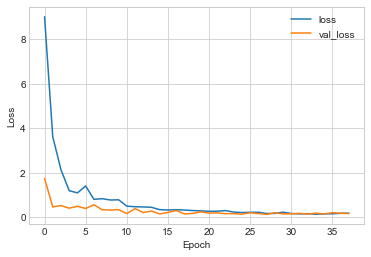

2/2 [==============================] - 0s 2ms/step


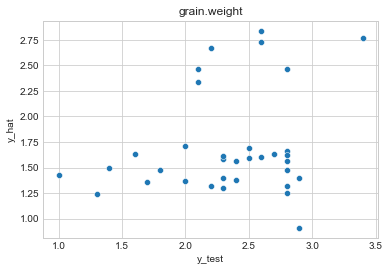

loss                  0.812044
mse                   0.812044
size_train          607.000000
size_test            34.000000
size_total          641.000000
grain.weight_cor      0.216706
dtype: float64


<Figure size 432x288 with 0 Axes>

In [21]:
# Save prediction results
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid")

pred_path = os.path.join(out_folder, "results")
if not os.path.isdir(pred_path):
    os.mkdir(pred_path)

# Training plot
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend(loc = "upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(os.path.join(pred_path, "training_loss_plot.png"), dpi = 300)
plt.show()
plt.clf()

# Compute metrics and prediction
eval_result = model.evaluate(x = X_test, y = y_test, return_dict = True)
pred_result = model.predict(X_test)

# Series of results
res = pd.Series(eval_result)

# Dataset size
size_train = y_train[traits[0]].shape[0]
size_test = y_test[traits[0]].shape[0]
size_total = size_train + size_test

res["size_train"] = size_train
res["size_test"] = size_test
res["size_total"] = size_total

# Compute extra metrics and do plots, depending on target type

for i in range(len(target_types)):
    y_test_i = y_test[traits[i]]
    
    if target_types[i] == "continuous":
        # Correlation
        if output_type == "single-output":
            pred_result_i = pred_result
        else:
            pred_result_i = pred_result[i]
        
        y_hat = pred_result_i
        cor = np.corrcoef(y_test_i, y_hat, rowvar = False)[0, 1]
        res[f"{traits[i]}_cor"] = cor
        
        # Correlation plot
        plot = sns.scatterplot(x = y_test_i.squeeze(), y = y_hat.squeeze())
        plot.set(xlabel = "y_test", ylabel = "y_hat", title = traits[i])
        plt.savefig(os.path.join(pred_path, f"cor_plot_{traits[i]}.png"), dpi = 300)
        plt.show()
        plt.clf()
    
    elif target_types[i] == "binary":
        # AUC
        if output_type == "single-output":
            pred_result_i = pred_result
        else:
            pred_result_i = pred_result[i]
        m = keras.metrics.AUC()
        m.update_state(y_test_i, pred_result_i)
        AUC = m.result().numpy()
        res[f"{traits[i]}_AUC"] = AUC
        
        # Confusion matrix plot
        y_hat = np.where(pred_result_i > 0.5, 1, 0)
        conf = confusion_matrix(y_test_i, y_hat)
        plot = sns.heatmap(conf, annot = True, cmap = "Blues")
        plot.set(xlabel = "y_hat", ylabel = "y_test", title = traits[i])
        plt.savefig(os.path.join(pred_path, f"conf_matrix_{traits[i]}.png"), dpi = 300)
        plt.show()
        plt.clf()
    
    # Save prediction just in case
    prediction = pd.DataFrame({
        "original_index": test_mask.index[test_mask == True],
        "prediction": pred_result_i.squeeze() 
    })
    prediction.to_csv(os.path.join(pred_path, f"prediction_{traits[i]}.csv"),
                      index = False, header = True)
    
print(res)
res.to_csv(os.path.join(pred_path, "results.csv"), index = True, header = False)

In [ ]:
# keras.utils.plot_model(model, show_shapes = True)